In [9]:
import pandas as pd
import numpy as np
from itertools import chain

# Hi-C utilities imports:
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag
from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorials rely on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

# Visualization imports:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.ticker import EngFormatter
import seaborn

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [10]:
binsize = 10_000

In [140]:
# create a functions that would return a series of rectangles around called dots
# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none", binsize=10000):
    """
    yield a series of rectangles around called dots in a given region
    """
    chr, start, end = region
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = (e1 - s1) // binsize
        width2 = (e2 - s2) // binsize
        start1 = (s1 - start) // binsize 
        start2 = (s2 - start) // binsize
        #print(s1, s2, e1, e2)
        print(width1, width2, start1, start2)
        if loc == "upper":
            yield patches.Rectangle((start2, start1 ), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((start1, start2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

## Load data

In [141]:
# Open cool file with Micro-C data:
clr_orig = cooler.Cooler(f"/Users/amulyagarimella/Documents/2241finalproject/data/GM12878.GSE115524/GM12878.GSE115524.Homo_Sapiens.CTCF.b1.mcool::resolutions/{binsize}")

clr_orig_5kb = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/data/GM12878.GSE115524/GM12878.GSE115524.Homo_Sapiens.CTCF.b1.mcool::resolutions/5000")

clr_roi_expected = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/outputs/imputed/HiCNN2/roi/2025-05-06_08-06-32/21_predicted_hic.cool::/")

clr_roi = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/outputs/imputed/HiCNN2/roi/2025-05-06_08-04-00/21_predicted_hic.cool::/")

clr_full = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/outputs/imputed/HiCNN2/full/2025-05-05_20-05-06/21_predicted_hic.cool::/")

In [142]:

# define genomic view that will be used to call dots and pre-compute expected

# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)


In [144]:
# Select only chromosomes that are present in the cooler.
hg38_arms = hg38_arms.set_index("chrom").loc['chr21'].reset_index()

In [145]:
hg38_arms

,chrom,start,end,name
0,chr21,0,12000000,chr21_p
1,chr21,12000000,46709983,chr21_q


## Original cooler

In [146]:
# intra-arm expected
expected = cooltools.expected_cis(
    clr_orig,
    view_df=hg38_arms,
    nproc=4,
)

INFO:root:creating a Pool of 4 workers
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


In [147]:
dots_df = cooltools.dots(
    clr_orig,
    expected=expected,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:creating a Pool of 4 workers
INFO:root:convolving 24 tiles to build histograms for lambda-bins
INFO:root:Done building histograms in 0.790 sec ...
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/dotfinder.py:977: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmin()  # index of the first positive difference
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/dotfinder.py:977: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmin()  # index of the first positive difference
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/co

### visualize

In [214]:
# define a region to look into as an example
chrom = "chr21"
start_bp = dots_df['start1'].iloc[0]
size_bp = np.max([(dots_df['start2'].iloc[0] - dots_df['start1'].iloc[0]), 1_000_000])

binsize = 10000

region = ('chr21', start_bp, (start_bp + size_bp))

In [215]:
region

('chr21', np.int32(13970000), np.int64(14970000))

1 1 37 49
Rectangle(xy=(49, 37), width=1, height=1, angle=0)


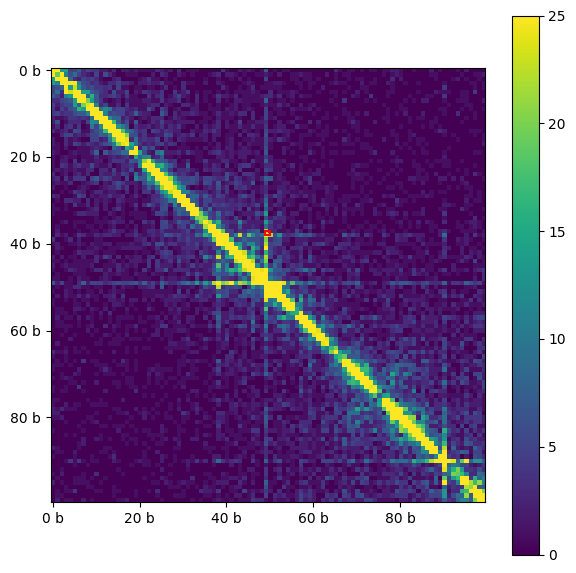

In [217]:
# compute heatmap for the region
region_matrix = clr_orig.matrix(balance=False).fetch(region_roi)
#for diag in [-1,0,1]:
#    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow(region_matrix,vmax=25)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df, region_roi, lw=1.5, ec="red"):
    print(box)
    ax.add_patch(box)

plt.show()

## Fully enhanced

In [150]:
# intra-arm expected
expected_full = cooltools.expected_cis(
    clr_full,
    view_df=hg38_arms,
    nproc=4,
)

INFO:root:creating a Pool of 4 workers
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


In [151]:
dots_df_full = cooltools.dots(
    clr_full,
    expected=expected_full,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:creating a Pool of 4 workers
INFO:root:convolving 24 tiles to build histograms for lambda-bins
INFO:root:Done building histograms in 0.689 sec ...
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/dotfinder.py:977: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmin()  # index of the first positive difference
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/dotfinder.py:977: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmin()  # index of the first positive difference
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/co

### visualize

1 1 0 49
Rectangle(xy=(49, 0), width=1, height=1, angle=0)


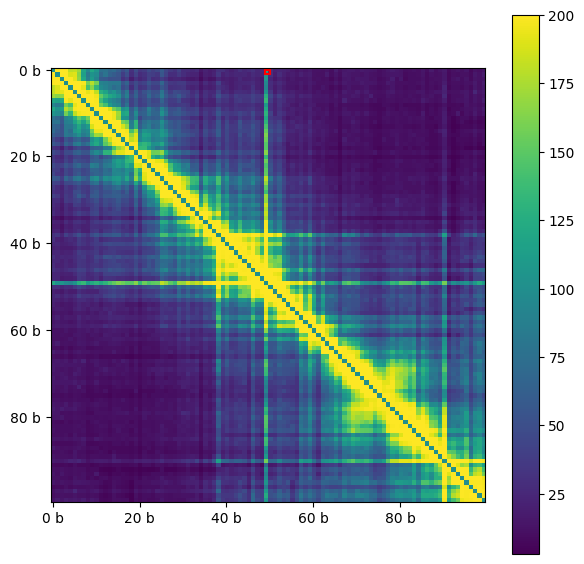

In [213]:

# compute heatmap for the region
region_matrix = clr_full.matrix(balance=False).fetch(region_roi)
#for diag in [-1,0,1]:
#    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow(region_matrix,vmax=200)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df_full, region_roi, lw=1.5, ec="red"):
    print(box)
    ax.add_patch(box)

plt.show()

## Enhanced at ROIs

In [173]:
# intra-arm expected
expected_roi = cooltools.expected_cis(
    clr_roi,
    view_df=hg38_arms,
    nproc=4,
)

INFO:root:creating a Pool of 4 workers
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


In [174]:
dots_df_roi = cooltools.dots(
    clr_roi,
    expected=expected_roi,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
)

dots_df_roi_v2 = cooltools.dots(
    clr_roi,
    expected=expected_roi,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
    clustering_radius=binsize*5,
    cluster_filtering=True
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:creating a Pool of 4 workers
INFO:root:convolving 24 tiles to build histograms for lambda-bins
INFO:root:Done building histograms in 0.659 sec ...
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/dotfinder.py:977: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmin()  # index of the first positive difference
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/dotfinder.py:977: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmin()  # index of the first positive difference
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/co

### visualize

1 1 0 29
Rectangle(xy=(29, 0), width=1, height=1, angle=0)
1 1 1 38
Rectangle(xy=(38, 1), width=1, height=1, angle=0)
1 1 2 22
Rectangle(xy=(22, 2), width=1, height=1, angle=0)
1 1 5 28
Rectangle(xy=(28, 5), width=1, height=1, angle=0)
1 1 6 29
Rectangle(xy=(29, 6), width=1, height=1, angle=0)
1 1 6 38
Rectangle(xy=(38, 6), width=1, height=1, angle=0)
1 1 7 33
Rectangle(xy=(33, 7), width=1, height=1, angle=0)
1 1 15 27
Rectangle(xy=(27, 15), width=1, height=1, angle=0)
1 1 14 37
Rectangle(xy=(37, 14), width=1, height=1, angle=0)
1 1 15 32
Rectangle(xy=(32, 15), width=1, height=1, angle=0)
1 1 19 31
Rectangle(xy=(31, 19), width=1, height=1, angle=0)
1 1 3 71
Rectangle(xy=(71, 3), width=1, height=1, angle=0)
1 1 5 70
Rectangle(xy=(70, 5), width=1, height=1, angle=0)
1 1 7 67
Rectangle(xy=(67, 7), width=1, height=1, angle=0)
1 1 0 95
Rectangle(xy=(95, 0), width=1, height=1, angle=0)
1 1 5 97
Rectangle(xy=(97, 5), width=1, height=1, angle=0)
1 1 9 99
Rectangle(xy=(99, 9), width=1, height=1

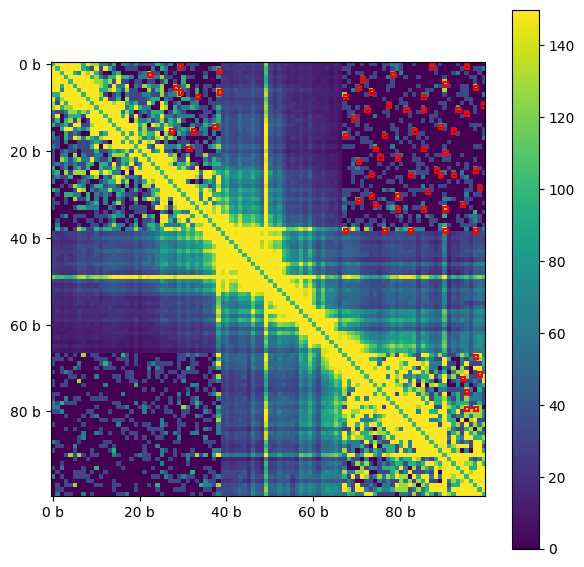

In [210]:
# compute heatmap for the region
region_matrix = clr_roi.matrix(balance=False).fetch(region_roi)
#for diag in [-1,0,1]:
#    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow(region_matrix,vmax=150)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df_roi, region_roi, lw=1.5, ec="red"):
    print(box)
    ax.add_patch(box)

plt.show()

In [208]:
offset = 950
region_roi = (region[0], region[1] + offset*binsize, region[2] + offset*binsize)

1 1 2 78
Rectangle(xy=(78, 2), width=1, height=1, angle=0)
1 1 6 73
Rectangle(xy=(73, 6), width=1, height=1, angle=0)
1 1 4 90
Rectangle(xy=(90, 4), width=1, height=1, angle=0)
1 1 14 89
Rectangle(xy=(89, 14), width=1, height=1, angle=0)
1 1 15 83
Rectangle(xy=(83, 15), width=1, height=1, angle=0)
1 1 16 67
Rectangle(xy=(67, 16), width=1, height=1, angle=0)
1 1 33 90
Rectangle(xy=(90, 33), width=1, height=1, angle=0)
1 1 30 79
Rectangle(xy=(79, 30), width=1, height=1, angle=0)
1 1 38 67
Rectangle(xy=(67, 38), width=1, height=1, angle=0)
1 1 38 90
Rectangle(xy=(90, 38), width=1, height=1, angle=0)
1 1 5 31
Rectangle(xy=(31, 5), width=1, height=1, angle=0)
1 1 19 31
Rectangle(xy=(31, 19), width=1, height=1, angle=0)


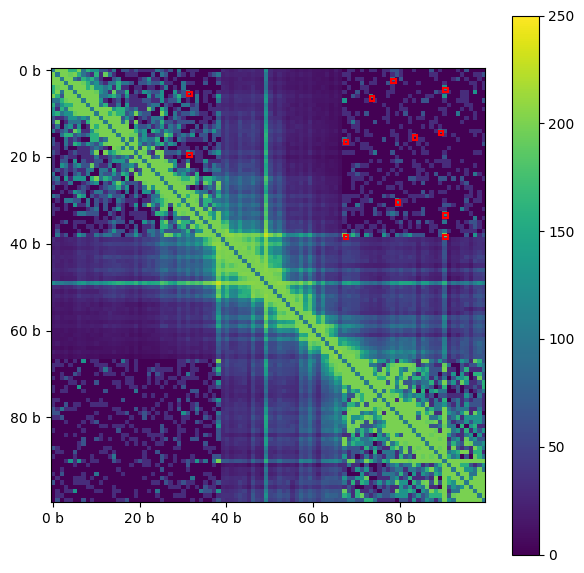

In [211]:
# compute heatmap for the region
region_matrix = clr_roi.matrix(balance=False).fetch(region_roi)
#for diag in [-1,0,1]:
#    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow(region_matrix,vmax=250)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df_roi_v2, region_roi, lw=1.5, ec="red"):
    print(box)
    ax.add_patch(box)

plt.show()